In [2]:
import requests
import os
import sys
import requests
import json
import shutil
import urllib.parse
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON


def download_image(url, directory):
    """
    Download an image from the given URL and save it to the specified directory.

    Args:
        url (str): The URL of the image to download.
        directory (str): The directory to save the downloaded image.

    Returns:
        int: The status code of the HTTP request.

    """
    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        filename = os.path.join(directory, os.path.basename(url))  # Get filename from URL
        # Decode the URL encoded filename to get readable text
        filename = urllib.parse.unquote(filename)
        with open(filename, "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
        return filename
    else: 
        return None

def create_json_file(image_filename, datas_directory, country):
    """
    Create a JSON file from the given pandas dataframe.

    Args:
        image_filename (str): The filename of the image.
        datas_directory (str): The directory to save the JSON file.
        country (str): The country of origin.

    """
    filename = os.path.splitext(os.path.basename(image_filename))[0]
    formatted_data = {
        "exif": {},
        "metadata": {"originCountry": country},
        "tags": {}
    }
    # Save the formatted data to a JSON file
    filepath = os.path.join(datas_directory, f"{filename}.json")
    with open(filepath, 'w') as f:
        json.dump(formatted_data, f, indent=4)
     

def get_results(endpoint_url, query):
    """
    Execute a SPARQL query on the given endpoint URL and return the results.

    Args:
        endpoint_url (str): The URL of the SPARQL endpoint.
        query (str): The SPARQL query to execute.

    Returns:
        dict: The JSON-formatted results of the SPARQL query.

    """
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

# SPARQL query
query = """
SELECT DISTINCT ?patisserie ?patisserieLabel ?image ?country ?countryLabel {
  ?patisserie wdt:P31*/wdt:P279* wd:Q477248;
          wdt:P18 ?image;
          wdt:P495 ?country.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
LIMIT 10
"""

# Wikidata SPARQL endpoint
wikidata_endpoint = "https://query.wikidata.org/sparql"

array = []
results = get_results(wikidata_endpoint, query)

# Extract the patisserie and image URL from the results
for result in results["results"]["bindings"]:
    array.append(
        (
            result["patisserieLabel"]["value"],
            result["image"]["value"],
            result["countryLabel"]["value"],
        )
    )

# Create a pandas dataframe from the array
dataframe = pd.DataFrame(array, columns=["patisserie", "image", "country"])
dataframe = dataframe.astype(
    dtype={"patisserie": "<U200", "image": "<U200", "country": "<U200"}
)

# Define the path to the images folder and datas folder
images_directory = "images"
datas_directory = "datas"

# Create directory to save datas and images
if not os.path.exists(images_directory):
    os.makedirs(images_directory)
if not os.path.exists(datas_directory):
    os.makedirs(datas_directory)

# Download the images in the specified directory
dataframe['image_filename'] = dataframe.image.apply(lambda x: download_image(x, images_directory))

# Create JSON files for each downloaded image
for _, row in dataframe.iterrows():
    image_filename = row['image_filename']
    country = row['country']
    if image_filename:
        create_json_file(image_filename, datas_directory, country)

In [4]:
import os
import json
import exifread
from PIL import Image

def extract_exif(filename):
    """
    Extracts EXIF data from the given image file.

    Args:
        filename (str): The path to the image file.

    Returns:
        dict: A dictionary containing the extracted EXIF data.
    """
    with open(filename, 'rb') as f:
        tags = exifread.process_file(f)
        return {str(tag): str(tags[tag]) for tag in tags}


def save_exif_data(exif_data, patisserie_name, directory):
    """
    Saves the EXIF data to a JSON file.

    Args:
        exif_data (dict): The EXIF data to be saved.
        patisserie_name (str): The name of the patisserie.
        directory (str): The directory where the JSON file will be saved.
    """
    filepath = os.path.join(directory, f"{patisserie_name}.json")
    with open(filepath, 'r') as f:
        existing_data = json.load(f)
        
    existing_data["exif"].update(exif_data)
    
    # Save the formatted data to a JSON file
    with open(filepath, 'w') as f:
        json.dump(existing_data, f, indent=4)

def get_image_orientation(image_path):
    """
    Get the orientation of the image based on its width and height.

    Args:
        image_path (str): The path to the image file.

    Returns:
        str: The orientation of the image ('portrait' or 'landscape').
    """
    with Image.open(image_path) as img:
        width, height = img.size
        if width > height:
            return 'landscape'
        elif width < height:
            return 'portrait'
        else:
            return 'square'


def save_image_metadata(image_path, patisserie_name, directory):
    """
    Saves the image metadata to a JSON file.

    Args:
        image_path (str): The path to the image file.
        patisserie_name (str): The name of the patisserie.
        directory (str): The directory where the JSON file will be saved.
    """

    filepath = os.path.join(directory, f"{patisserie_name}.json")
    with open(filepath, 'r') as f:
        existing_data = json.load(f)
        
    # Get image orientation
    orientation = get_image_orientation(image_path)
        
    existing_data["metadata"]["orientation"] = orientation
        
    # Save the formatted data to a JSON file
    with open(filepath, 'w') as f:
        json.dump(existing_data, f, indent=4)


# Define the path to the images folder and datas folder
images_directory = "images"
datas_directory = "datas"

# Iterate over each file in the folder
for filename in os.listdir(images_directory):
    file_path = os.path.join(images_directory, filename)
    
    # Check if the path is a file (not a directory)
    if os.path.isfile(file_path):
        # Get the patisserie name from the filename
        patisserie_name = os.path.splitext(filename)[0]
        
        # Extract EXIF data
        exif_data = extract_exif(file_path)
        
        # Save EXIF data
        save_exif_data(exif_data, patisserie_name, datas_directory)
        
        # Save image metadata
        save_image_metadata(file_path, patisserie_name, datas_directory)



Possibly corrupted field RecordingMode in MakerNote IFD
Possibly corrupted field RecordingMode in MakerNote IFD
Possibly corrupted field RecordingMode in MakerNote IFD
Possibly corrupted field RecordingMode in MakerNote IFD
Possibly corrupted field RecordingMode in MakerNote IFD
Possibly corrupted field RecordingMode in MakerNote IFD


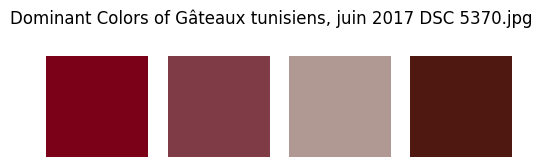

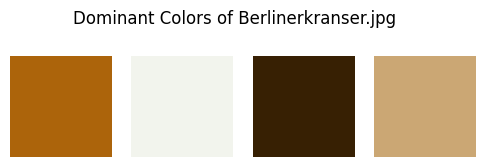

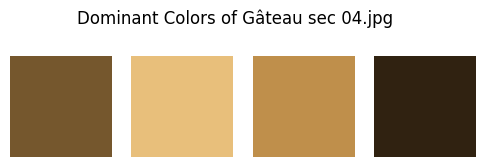

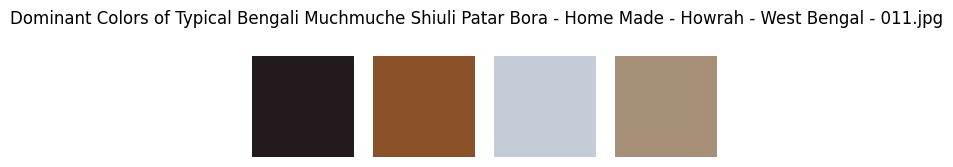

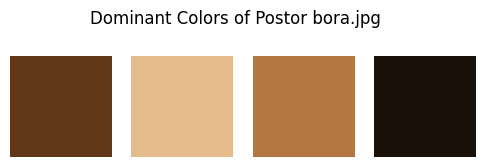

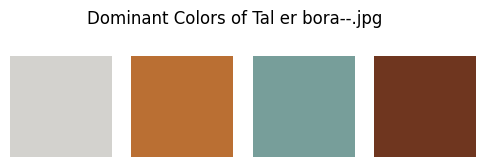

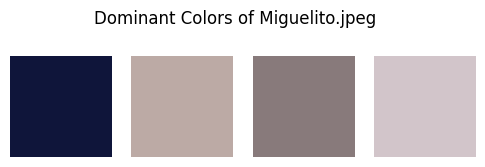

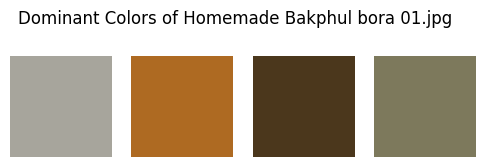

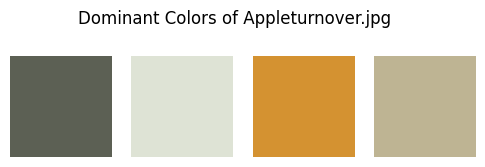

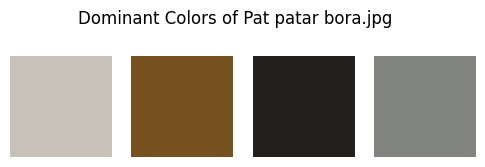

In [10]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans


def extract_dominant_colors(image):
    """
    Extracts the dominant colors from an image using K-means clustering.

    Parameters:
    - image: PIL.Image object representing the input image.

    Returns:
    - dominant_colors: Array of RGB values representing the dominant colors in the image.
    """
    numarray = np.array(image.getdata(), dtype=np.uint8)
    clusters = KMeans(n_clusters=4, n_init=2)
    clusters.fit(numarray)
    return clusters.cluster_centers_

# Specify the path to the directory containing images
images_directory = "images"

# Iterate over each file in the images directory
for filename in os.listdir(images_directory):
    image_filename = os.path.join(images_directory, filename)
    # Check if the path is a file (not a directory)
    if os.path.isfile(image_filename):
        try:
            # Open the image
            image = Image.open(image_filename)
            # Extract dominant colors
            dominant_colors = extract_dominant_colors(image)

            # Plot dominant colors
            plt.figure(figsize=(6, 2))
            for i, color in enumerate(dominant_colors):
                plt.subplot(1, 4, i + 1)
                plt.imshow([[color / 255]])
                plt.axis('off')
            plt.suptitle(f"Dominant Colors of {filename}")
            plt.show()

        except Exception as e:
            print(f"Error processing {image_filename}: {e}")


Le bloc de code suivant sélectionne aléatoirement 10 images, demande à l'utilisateur de saisir un mot pour qualifier chaque image, gère les métadonnées associées à chaque image en enregistrant les tags dans des fichiers JSON, puis ferme l'affichage de chaque image après la saisie du tag.

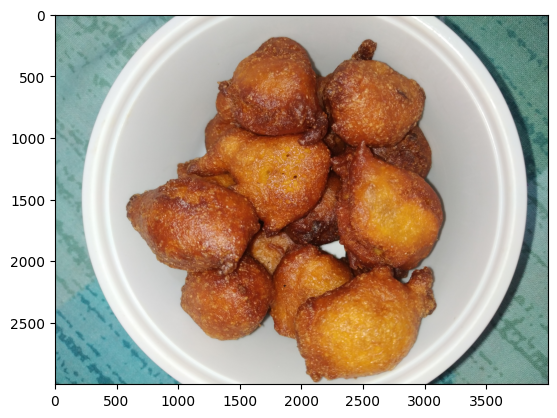

KeyboardInterrupt: Interrupted by user

In [11]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import json
import time

# Récupérer la liste des images
image_dir = "images"
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Choisir 10 images au hasard
selected_images = random.sample(image_files, 10)

# Define the data directory
data_dir = "datas"

for image_file in selected_images:
    # Afficher l'image
    img = Image.open(os.path.join(image_dir, image_file))
    plt.imshow(img)
    plt.show(block=False)
    time.sleep(1)  # Pause pour donner le temps à l'image de s'afficher

    # Demander à l'utilisateur d'entrer un mot pour qualifier l'image
    tag = input("Entrez un mot pour qualifier cette image: ")

    # Lecture du fichier JSON existant dans le data directory
    json_file = os.path.join(data_dir, os.path.splitext(image_file)[0] + ".json")
    if os.path.exists(json_file):
        try:
            with open(json_file, 'r') as file:
                image_data = json.load(file)
        except json.JSONDecodeError:
            print(f"Error decoding JSON for {image_file}. Skipping this file.")
            image_data = {}
    else:
        print(f"No JSON file found for {image_file} in the data directory.")
        image_data = {}

    # Ajout du tag dans la balise "tags"
    if 'tags' not in image_data:
        image_data['tags'] = {}
    elif not isinstance(image_data['tags'], dict):
        # Si c'est une liste, convertir en dictionnaire
        tag_list = image_data['tags']
        image_data['tags'] = {tag: 0 for tag in tag_list}
    # Incrémenter le nombre d'occurrences du tag
    image_data['tags'][tag] = image_data['tags'].get(tag, 0) + 1

    # Écriture dans le fichier JSON in the data directory
    with open(json_file, 'w', encoding='utf-8') as file:
        json.dump(image_data, file, ensure_ascii=False, indent=4)

    # Fermer l'image
    plt.close()


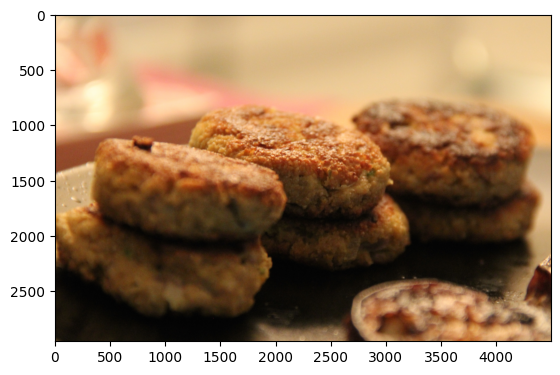

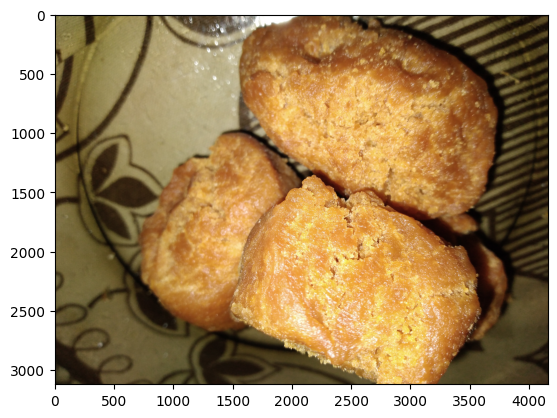

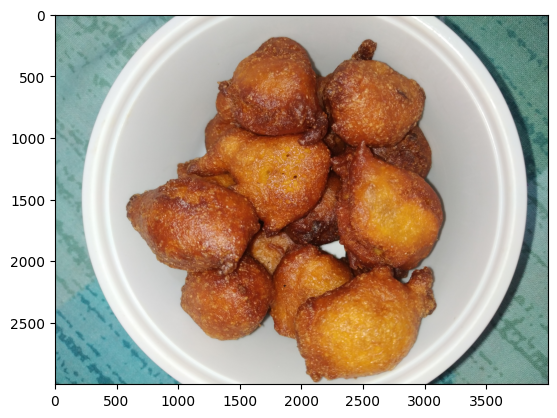

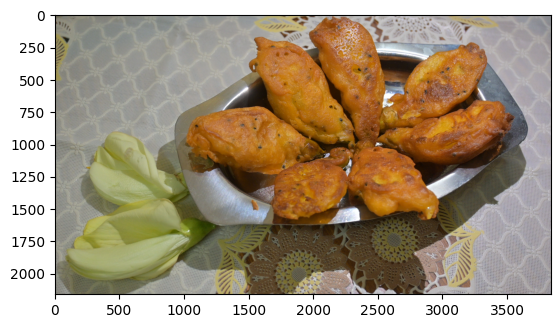

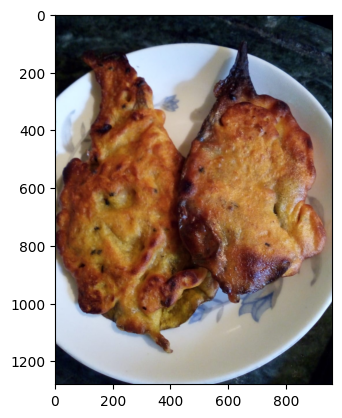

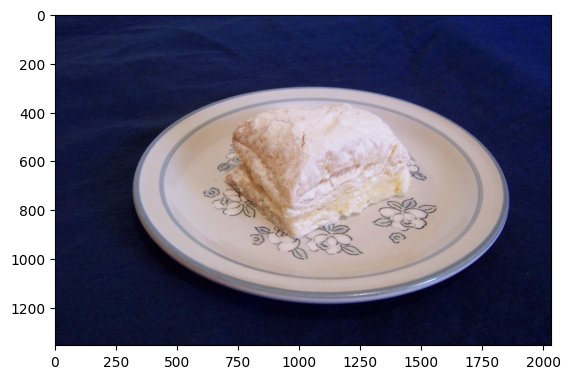

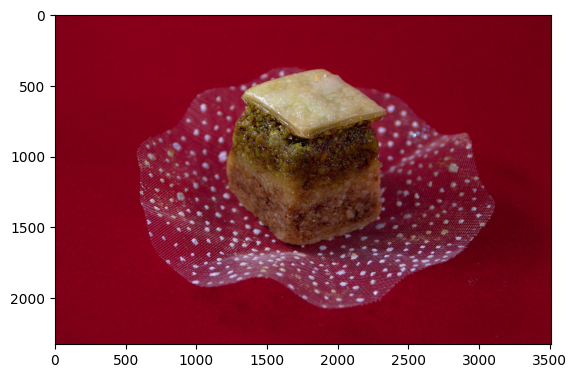

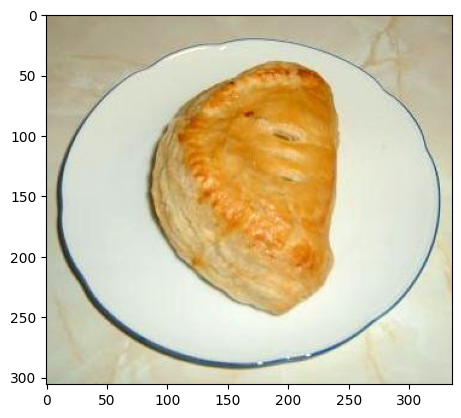

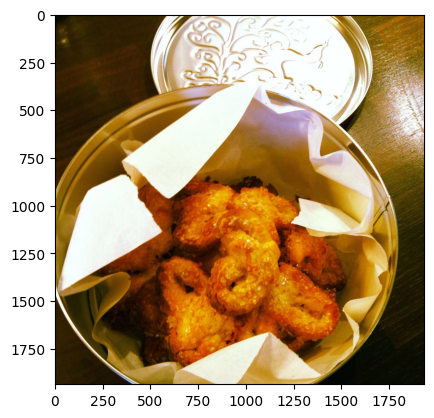

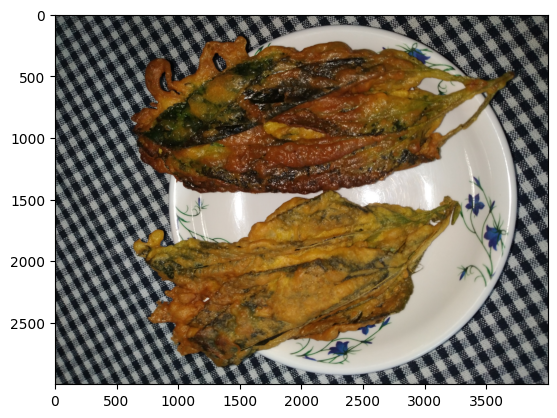

In [ ]:
import os
import json
import matplotlib.pyplot as plt

# Répertoire des données
data_dir = "datas"

# Parcourir tous les fichiers JSON dans le répertoire des données
for json_file in os.listdir(data_dir):
    if json_file.endswith('.json'):
        # Charger les données JSON
        with open(os.path.join(data_dir, json_file), 'r') as file:
            image_data = json.load(file)
        
        # Récupérer le nom de l'image à partir du nom du fichier JSON
        image_name = os.path.splitext(json_file)[0]
        
        # Récupérer les tags de l'image
        tags = image_data.get('tags', [])
        
        # Initialisation d'un dictionnaire pour stocker les tags et leur fréquence
        tag_frequency = {}
        
        # Mettre à jour le dictionnaire de fréquence des tags
        for tag in tags:
            # Convertir le tag en chaîne de caractères s'il s'agit d'un dictionnaire
            if isinstance(tag, dict):
                tag = str(tag)
            tag_frequency[tag] = tag_frequency.get(tag, 0) + 1
        
        # Affichage du graphe en barres des tags et de leur fréquence
        plt.figure(figsize=(10, 6))
        plt.bar(tag_frequency.keys(), tag_frequency.values())
        plt.xlabel('Tags')
        plt.ylabel('Nombre de mentions')
        plt.title(f'Fréquence des tags pour {image_name}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
